In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
IMG_DIR = "C:\\Users\\Personal\\Downloads\\shrivanshi\\data\\images"
CSV_FILE = "C:\\Users\\Personal\\Downloads\\shrivanshi\\data\\dataset_details.csv"
num_classes = 3

#### Preprocessing

In [3]:
df = pd.read_csv(CSV_FILE)
mapping = {'tirads2': 0, 'tirads3': 1, 'tirads5': 2}
df['tirads_class'] = df['image_label'].map(mapping)
df = df.drop("Unnamed: 0", axis=1)
df.head()

,image_name,image_label,tirads_class
0,tirads_2_1.jpg,tirads2,0
1,tirads_2_10.jpg,tirads2,0
2,tirads_2_11.jpg,tirads2,0
3,tirads_2_12.jpg,tirads2,0
4,tirads_2_13.jpg,tirads2,0


In [4]:
images, labels = [], []

for _, row in df.iterrows():
    image_name, _, label = row

    image = cv2.imread(os.path.join(IMG_DIR,image_name))
    image = cv2.resize(image, (256,256), interpolation = cv2.INTER_LINEAR)
    images.append(image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#### Model Training

In [11]:
model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 3))

# Add classification layer
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define full model
model = Model(inputs=model.input, outputs=predictions)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint('models/task_1.h5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(patience = 10, monitor='val_loss')
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose = 1, min_delta=0.001, factor = 0.1, patience =2, mode='min', min_lre = 0.00001)

callbacks = [checkpointer, earlystopper, reduce_LR]

In [12]:
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=100,
    validation_split=0.1,
    shuffle=True,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/100
2/3 [===================>..........] - ETA: 0s - loss: 2.1787 - accuracy: 0.3125
Epoch 1: val_loss improved from inf to 46.26109, saving model to models\task_1.h5
3/3 [==============================] - 5s 759ms/step - loss: 2.1127 - accuracy: 0.2778 - val_loss: 46.2611 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2.3469 - accuracy: 0.3611
Epoch 2: val_loss did not improve from 46.26109
3/3 [==============================] - 0s 121ms/step - loss: 2.3469 - accuracy: 0.3611 - val_loss: 244.2000 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.2902 - accuracy: 0.5278
Epoch 3: val_loss did not improve from 46.26109

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 [==============================] - 0s 123ms/step - loss: 1.2902 - accuracy: 0.5278 - val_loss: 1268.2988 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
3/3 [================

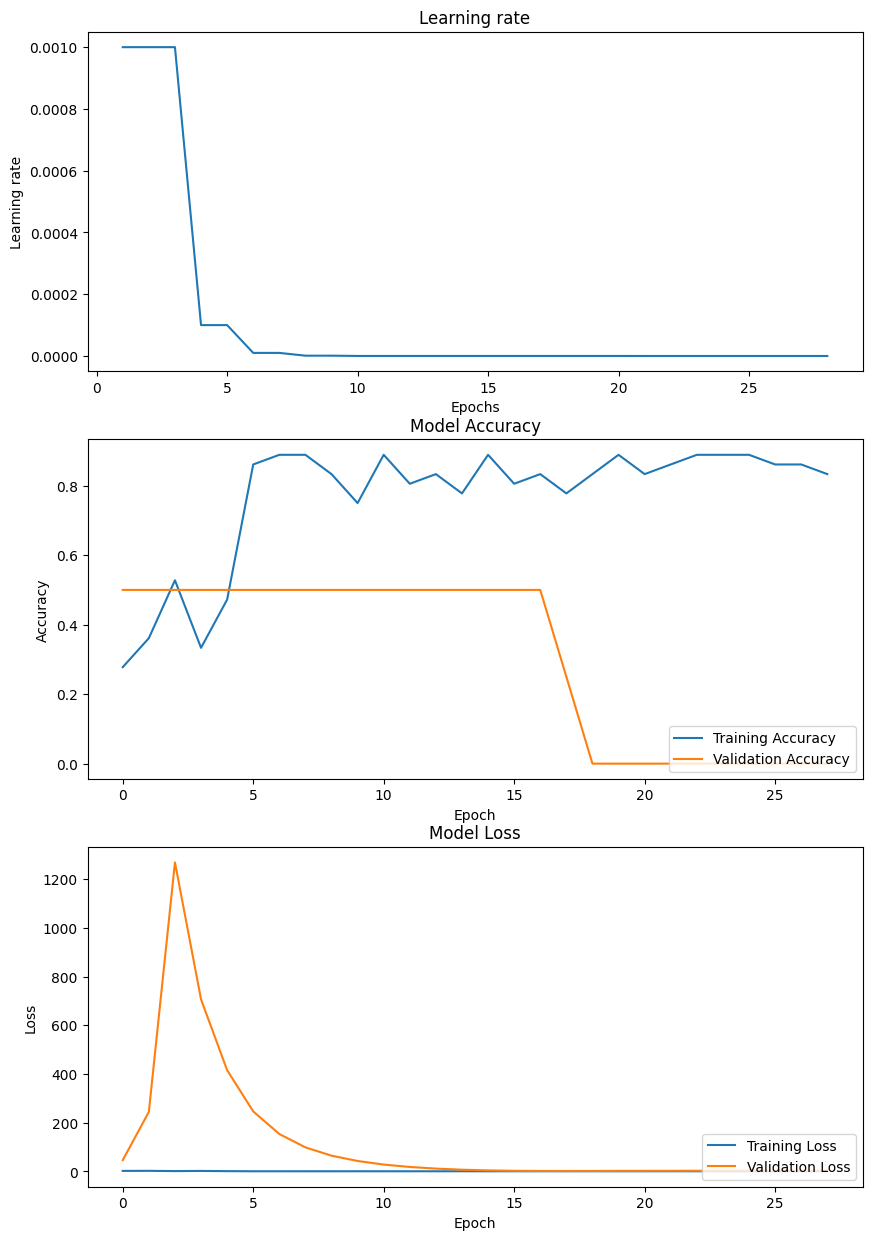

In [15]:
hist = history.history

# Plot Learning Rate
learning_rate = hist['lr']
epochs = range(1, len(learning_rate) + 1)

plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.plot(epochs, learning_rate)
plt.title('Learning rate')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')

plt.subplot(312)
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"], loc ="lower right")

plt.subplot(313)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"], loc ="lower right")

plt.show()

In [16]:
model = load_model('models/task_1.h5')
metrics = model.evaluate(x_test, y_test)

predictions = model.predict(x_test)

1/1 [==============================] - 1s 586ms/step


In [10]:
y_test = np.argmax(y_test,axis=1)
predictions = np.argmax(predictions, axis=1)

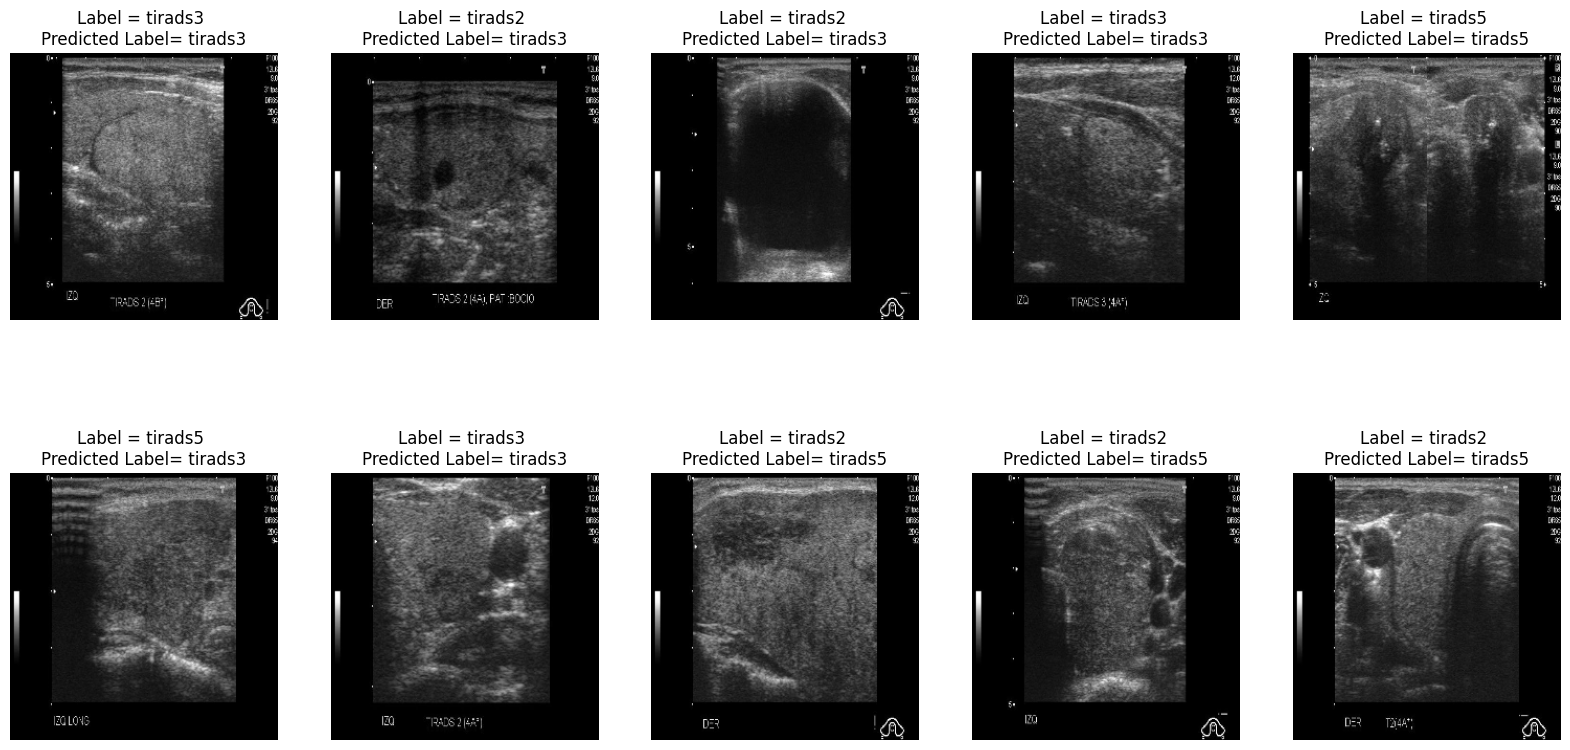

In [11]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(x_test[i])
    plt.title(f'Label = {[k for k, v in mapping.items() if v == y_test[i]][0]} \nPredicted Label= {[k for k, v in mapping.items() if v == predictions[i]][0]}')
plt.show()